In [31]:
import numpy as np 
import copy
import torch

from IMP_CW_env import MESCEnv
from utils import plot_reward_evolution, read_log_file, plot_reward_distribution

%matplotlib inline
# %matplotlib ipympl
import matplotlib.pyplot as plt

# **1. Training environment definition**
[comment]: <> (Check why it is only working when "Run all" and not when cells are run individually)

In [32]:
n_retailers = 2
n_DCs = 1
n_suppliers = 1
supply_chain_structure = [[n_retailers] , [n_DCs], n_suppliers]

env_train = MESCEnv(supply_chain_structure)

# **2. Policy Network**
[comment]: <> (MLPregresor from sklearn is not used because you cannot specify input and output shapes prior to calling the fit method. Since in the ES approach it won't be used, we build NN using Pytorch.)

In [33]:
class PolicyNetwork(torch.nn.Module):
    def __init__(self, input_size, output_size, h1_size = 128, h2_size = 64):
        super(PolicyNetwork, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, h1_size)
        self.fc2 = torch.nn.Linear(h1_size, h2_size)
        self.fc3 = torch.nn.Linear(h2_size, output_size)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return x

# **3. Policy optimization**
To obtain the optimal policies, different methods can be used. 
- **Heuristic methods**, like the (s,S) policy
- **Evolutionary algorithms**, like simulated annealing (SA) or particle-swarm optimization (PSO).
- **RL-specific algorithms**, such as Q-learning or REINFORCE.

In this coursework, you are asked to implement from skratch Simulated Annealing method. 

Simulated Annealing is a simple optimization technique inspired by the thermodynamic process of cooling metal. The algorithm iteratively explores the feasible region, accepting better solutions and, at times, worse solutions based on a probability function driven by temperature. Over time, the "temperature" decreases, reducing the likelihood of accepting worse solutions. 

You can find more information about it [here](https://www.baeldung.com/cs/simulated-annealing), but the basic flowchart is shown below.

<div>
<img src="https://www.baeldung.com/wp-content/uploads/sites/4/2023/03/flowchart.png" width="500"/>
</div>


Please, write your code in the following cell, where you have to define a function that executes your optimizaiton algorithm.

You will be evaluated based on the content of this cell, since we will run your implementation on a different environment with a limited budget (maximum running time or maximum timesteps). So, please, make sure any auxiliary functions that are called within your main optimization function are also included.

In [34]:
#################################
# Helper functions
#################################

def sample_uniform_params(params_prev, param_min, param_max):
    '''
    Sample random point within given parameter bounds. Tailored for EXPLORATORY purposes
    '''
    params = {k: torch.rand(v.shape) * (param_max - param_min) + param_min \
              for k, v in params_prev.items()}
    return params

def sample_local_params(params_prev, param_min, param_max):
    '''
    Sample a random point in the neighborhood of a given point or value or the parameters (v). Tailored for EXPLOITATION purposes

    Explanation:
    sign = (torch.randint(2, (v.shape)) * 2 - 1) # This returns either -1 or 1
    eps = torch.rand(v.shape) * (param_max - param_min) # This returns the width of the step to be taken in the modification of the parameters
    Hence, the total update is: v + sign*eps.
    '''
    params = {k: torch.rand(v.shape) * (param_max - param_min) * (torch.randint(2, (v.shape))*2 - 1) + v \
              for k, v in params_prev.items()}
    return params

#####################
# Objective function 
######################
def reward_fcn(policy_net, env, num_episodes=10, demand=None):
    '''
    Runs an episode and computes the total return.
    '''
    assert num_episodes > 0, "Number of episodes must be greater than 0"

    env.demands_episode = demand
    env.reset()
    
    episode_terminated = False
    state = env.state
    reward_list = []

    for _ in range(num_episodes):
        total_reward = 0
        while episode_terminated == False:
            # Pre-process state
            state = torch.FloatTensor(state)

            # Get action according to the policy network
            action_mean = policy_net(state)
            action_mean = action_mean.detach().numpy()
            action_mean = np.floor(action_mean)

            # Interact with the environment to get reward and next state
            state , reward, episode_terminated, _ = env.step(action_mean)
            total_reward += reward
        reward_list.append(total_reward)

    mean_reward = np.mean(reward_list)
    std_reward = np.std(reward_list)
    return mean_reward, std_reward

#################################
# 2-Phase Policy Optimization
#################################
def optimization_algorithm(env,
                           param_min = -1.,
                           param_max = 1.,
                           num_episodes_avg = 10 ,
                           iter = 100, 
                           ratio_rs_ls = 0.1, 
                           NNparams_0 = None,
                           initial_temp = 1e5, 
                           ):
    
    assert initial_temp > 0 , "inital_temp must be a positive value"

    # Setup iterations
    iter_rs = round(iter * ratio_rs_ls)
    iter_ls = iter - iter_rs

    # Initialize buffers to store data for plotting
    reward_history = []
    std_history = []
    best_reward_history = []

    # Policy initialization
    policy_net = PolicyNetwork(input_size=env.observation_space.shape[0], 
                               output_size=env.action_space.shape[0])
    param = policy_net.state_dict() if NNparams_0 is None else NNparams_0 

    # Initialization
    best_param = copy.deepcopy(param)
    best_reward, best_std = reward_fcn(policy_net, env)
    reward_history.append(best_reward)
    std_history.append(best_std)
    best_reward_history.append(best_reward)

    # ###########################################################   
    # Random search phase: generate good initial solution
    # ###########################################################
    if NNparams_0 is None:
        for i in range(iter_rs):
            # Sample a random policy
            param = sample_uniform_params(best_param, param_min, param_max)
            # Construct the policy network with the sampled parameters
            policy_net.load_state_dict(param)
            # Evaluate the policy
            reward, std = reward_fcn(policy_net, env, num_episodes=num_episodes_avg)
            reward_history.append(reward)
            std_history.append(std)

            if not np.isfinite(reward):
                print(f"Reward overflow: {reward}")

            # Check if the new policy is better than the best one found so far
            if reward > best_reward:
                best_reward = reward
                best_param = copy.deepcopy(param)

            # Store the best reward found so far for plotting
            best_reward_history.append(best_reward)

    # ###########################################################
    # Local search phase: Simulated Annealing
    # ###########################################################

    # Set current working solution
    current_param = copy.deepcopy(best_param)
    current_reward = best_reward

    for i in range(iter_ls):
        # Sample a new policy in the neighborhood of the current one
        # TODO: check if ok or leave it like sample_uniform_params
        candidate_param = sample_uniform_params(best_param, param_min, param_max)
        
        # Evaluate the candidate policy
        policy_net.load_state_dict(candidate_param)
        candidate_reward, std = reward_fcn(policy_net, env, num_episodes=num_episodes_avg)

        # Check if the candidate policy is better than the current one
        if candidate_reward > best_reward:
            # Update the new best policy
            best_reward = candidate_reward
            best_param = copy.deepcopy(candidate_param)
            
        # Check if the candidate policy should be kept or discarded
        diff = candidate_reward - current_reward
        temp = initial_temp / (1 + i) # update temperature paramter
        metropolis = np.exp(diff/temp) # compute metropolis acceptance probability
        if diff > 0 or np.random.rand() < metropolis:
            # Update the current policy 
            current_param = copy.deepcopy(candidate_param)
            current_reward = candidate_reward
        
        # Store the data for plotting
        reward_history.append(candidate_reward)
        std_history.append(std)
        best_reward_history.append(best_reward)

    # Pack data for plotting
    plot_info = {'reward_history': reward_history,
                 'std_history': std_history,
                 'best_reward_history': best_reward_history}
        
    return best_param, best_reward, plot_info

# **4. Policy training**

Before calling your optimization algorithm, write all the (argument,value) pairs that your function takes as inputs as a Python `dict`. You will also be asked to submit it together with your training function so that we run it with the optimal configuration of hyperparameters you have found so far.

In [35]:
hyperparam = {}
# Problem specs 
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# TODO: how do I know the bounds of the nn weights?
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
hyperparam['param_min'] = -1.
hyperparam['param_max'] = 1.
hyperparam['num_episodes_avg'] = 10
# Algorithm-specific hyperparameters
hyperparam['initial_temp'] = 1e7
hyperparam['iter'] = 250
hyperparam['ratio_rs_ls'] = .05

By running the cell below, your training algorithm will be executed using the hyperparameter configuration you defined below.

In [36]:
np.seterr(over='ignore')  # Suppress overflow warnings
# np.seterr(over='warn')  # Re-enable overflow warnings

best_param, best_reward, plot_info = optimization_algorithm(env_train, **hyperparam)
print(f"Best reward: {best_reward}")

Best reward: 14411.6


Visualize training results.

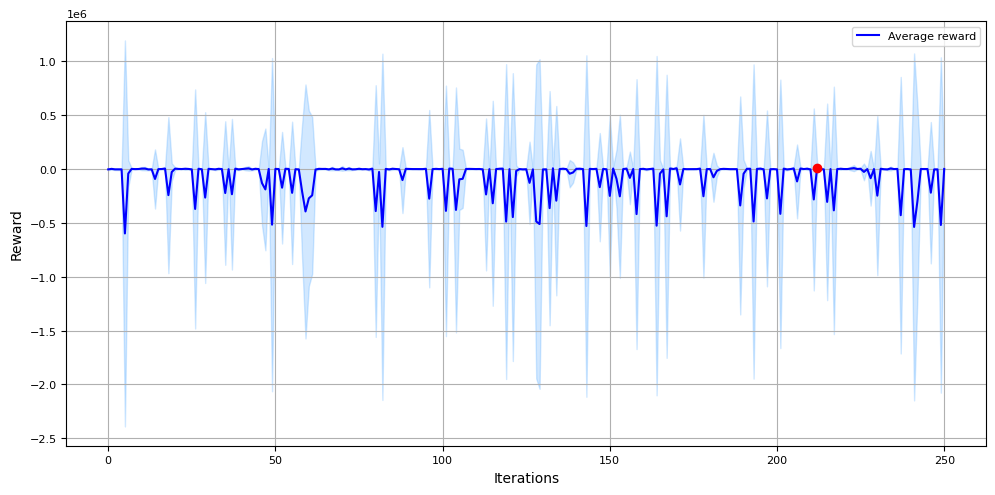

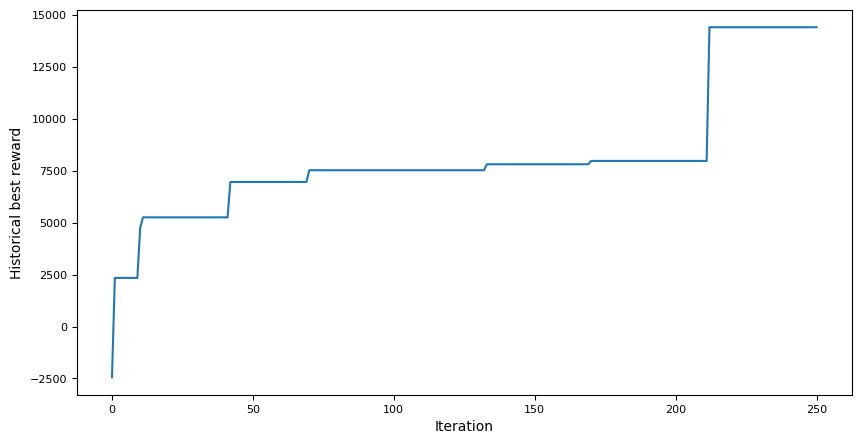

In [37]:
# Plot solution evolution per iteration
plot_reward_evolution(list(range(len(plot_info['reward_history']))), plot_info['reward_history'], reward_std=plot_info['std_history']);

# Plot historical best reward
plt.plot(list(range(len(plot_info['best_reward_history']))), plot_info['best_reward_history'])
plt.xlabel('Iteration')
plt.ylabel('Historical best reward');

# **5. Policy evaluation**
### **5.1. Test data**: get new demand scenarios
The variable test_demand_dataset contains 100 samples of demand scenarios, each with 52 weeks, that will be used for testing and comparing the extrapolation capabilities of the different policies.

In [38]:
import pickle
# Open the file in binary mode
with open("test_demand_dataset.pickle", 'rb') as file:
    # Deserialize and retrieve the variable from the file
    test_demand_dataset = pickle.load(file)

### **5.2. Load best policy found so far**

In [39]:
policySA = PolicyNetwork(input_size=env_train.observation_space.shape[0], output_size=env_train.action_space.shape[0]) 
policySA.load_state_dict(best_param)

<All keys matched successfully>

### **5.3. Evaluation**
First, define and execute the test function.

In [40]:
reward_list = []
for demand in test_demand_dataset:
    reward, _ = reward_fcn(policySA, env_train, num_episodes=1, demand=demand)
    reward_list.append(reward)

In [41]:
print("Performance of the simulated annealing:\n - Average reward: {:.0f}\n - Reward standard deviation: {:.2f}".format(np.mean(reward_list), np.std(reward_list)))

Performance of the simulated annealing:
 - Average reward: 57106
 - Reward standard deviation: 39927.14


Compare to heuristic policy.

In [42]:
from HeuristicPolicy_file import HeuristicPolicy

sSpolicy = HeuristicPolicy()
sSpolicy.policy_param = np.array([19., 34., 17., 25., 79., 138.])
reward_list_sS = sSpolicy.evaluate_policy(env_train, test_demand_dataset)

In [43]:
print("Heuristic policy performance:\n - Average reward: {:.0f}\n - Reward standard deviation: {:.2f}".format(np.mean(reward_list_sS), np.std(reward_list_sS)))

Heuristic policy performance:
 - Average reward: 121754
 - Reward standard deviation: 34093.37


Visualize reward distribution

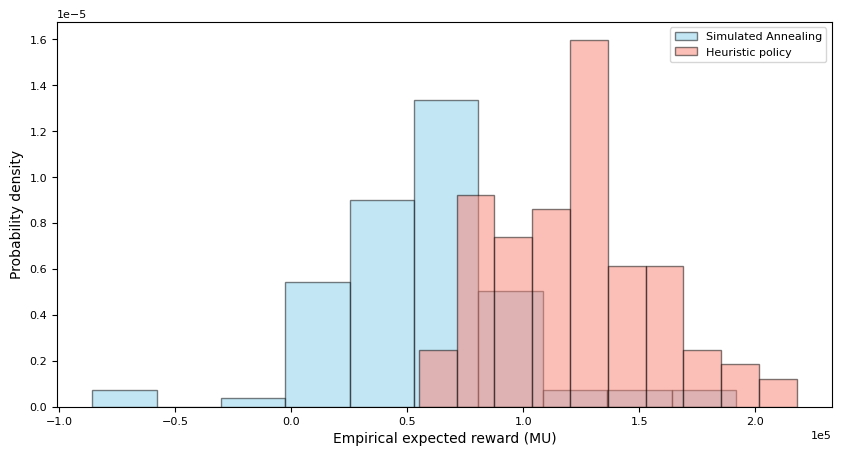

In [44]:
from utils import plot_reward_distribution
plot_reward_distribution(np.vstack([reward_list,reward_list_sS]).T, labels=['Simulated Annealing', 'Heuristic policy'])